# BOOM Dataset preprocessing for Machine Learning evaluation

This notebook describes the filtering process of the BOOM dataset, to make it suitable for the machine learning evaluation. In the MachineLearning notebook, we evaluate the performance of different classification algorithms in identifying the volcanic source of a sample based in its geochemical composition. Here we prepare the data so that it is suitable for this purpose.

The procedures in this notebook then define the "Preprocessing" function, which is called in the MachineLearning notebook.

In [2]:
#load relevant libraries
import pandas as pd
import numpy as np
import missingno as msno

# Load BOOM dataset

In [20]:
import requests
from io import StringIO

#Download the dataset from the ESPRI server as .csv
url = "https://data.ipsl.fr/repository/TephraDatabase/TephraDataBase.csv"
s=requests.get(url).text
df = pd.read_csv(StringIO(s), encoding="latin1", low_memory=False)

#in case the ESPRI server is down:
#df = pd.read_csv("../assets/Data/BOOMDataset.csv", encoding = 'UTF-8', low_memory =False )

In [21]:
df.describe()

,Magnitude,VEI,Latitude,Longitude,14C_Age,14C_Age_Error,40Ar39Ar_Age,40Ar39Ar_Age_Error,SiO2,TiO2,...,FeO_normalized,Fe2O3_normalized,Fe2O3T_normalized,FeOT_normalized,MgO_normalized,CaO_normalized,Na2O_normalized,K2O_normalized,Cl_normalized,Total_normalization
count,5533.000000,3984.000000,16768.000000,16768.000000,414.000000,414.000000,10.000000,10.00000,13225.000000,13225.000000,...,407.000000,407.000000,697.000000,12774.000000,13593.000000,13593.000000,13593.000000,13593.000000,4646.000000,13026.000000
mean,4.645527,4.596135,-41.559759,-72.109693,6055.048309,61.932367,10441.800000,1850.20000,63.531704,0.978370,...,7.126757,2.557220,8.389358,5.833811,1.942304,4.348837,4.481173,2.059293,0.147719,98.751745
std,0.938234,0.700271,3.212183,0.856737,4366.262935,46.109148,5742.516402,1136.15353,7.141434,0.568109,...,2.373362,1.123712,2.259415,3.368311,1.741784,2.723194,0.872142,0.951101,0.061761,1.605344
min,2.000000,2.000000,-53.750000,-75.680000,90.000000,19.000000,18.000000,2.00000,45.972845,0.000000,...,0.290000,0.150000,1.399078,0.120000,0.000000,0.345768,0.983520,0.008971,0.001000,89.403912
25%,4.000000,4.000000,-42.890833,-72.419000,2203.750000,35.000000,6525.000000,1100.00000,56.624000,0.521100,...,5.414728,2.168552,6.859209,3.244645,0.515906,1.964002,3.800182,1.198177,0.097194,97.888700
50%,5.000000,5.000000,-40.369600,-71.972000,5210.000000,50.000000,11750.000000,1750.00000,64.403495,0.950000,...,8.066789,2.304364,8.780282,4.805692,1.243199,3.441494,4.536318,1.904998,0.143800,98.975950
75%,5.300000,5.000000,-39.546000,-71.630000,9543.000000,70.000000,14250.000000,2700.00000,69.539900,1.366700,...,8.547477,2.601469,10.016435,9.107538,3.222522,6.861193,5.144314,2.920075,0.191679,99.817983
max,6.200000,6.000000,-38.438690,-68.700000,17774.000000,400.000000,18700.000000,3800.00000,79.611240,6.280000,...,11.530120,8.005325,15.440233,15.311673,16.174723,12.001885,7.781000,5.880588,0.610061,103.070000


In [22]:
n, p = df.shape
print(f'This dataset consists of {n} samples and {p} variables.')

This dataset consists of 16768 samples and 100 variables.


The target variable will be the volcano ID, i.e. the machine learning will be used to predict the volcano ID of a sample, given its geochemistry. Let's look at them.

In [23]:
y = len(df[df.Volcano!='Unknown']['Volcano'].unique())
print(f'There are {y} different volcanos.')
df[df.Volcano!='Unknown']['Volcano'].value_counts()

There are 32 different volcanos.


Mocho-Choshuenco         2691
Chaitén                  2343
Puyehue-Cordón Caulle    1924
Llaima                   1479
Quetrupillán             1214
Hudson                    994
Villarrica                865
Michinmahuida             629
Melimoyu                  464
Monte Burney              421
Antillanca-Casablanca     242
Reclus                    193
Carrán-Los Venados        186
Calbuco                   179
Huanquihue Group          176
Caburga-Huelemolle        135
Mentolat                  121
Osorno                    102
Lanín                      91
Sollipulli                 75
Apagado                    48
Aguilera                   45
Yate                       43
Lautaro                    41
Macá                       27
Hornopirén                 27
Subsidiary Vcha dome       21
Cay                        17
Corcovado                  11
Huequi                     11
Yanteles                    7
Cordón Cabrera              4
Name: Volcano, dtype: int64

1. In order to prepare the dataset for the Machine learning analyss, first of all we drop rows corresponding to samples not analyzed for geochemistry, as well as outliers, samples for which the volcanic source is uncertain, and samples with Analytical Totals lower than 94 wt.%, as they might correspond to altered samples.

In [24]:
df['TypeOfRegister'].value_counts()

Pyroclastic material    15851
Organic matter            413
Effusive material         401
Name: TypeOfRegister, dtype: int64

In [25]:
is_register = df.TypeOfRegister.isin(['Pyroclastic material','Effusive material'])

In [26]:
df['Flag'].value_counts(dropna=False)

NaN                                                    10364
EventName_Issue                                         2249
Geochemistry_Issue                                      1715
SampleID_Issue                                           549
Position_Issue                                           547
Position_Issue, EventName_Issue                          244
DOI_Issue                                                209
VolcanicSource_Issue                                     188
Position_Issue, Geochemistry_Issue                       127
SampleID_Issue, Geochemistry_Issue                        90
DOI_Issue, Geochemistry_Issue                             87
VolcanicSource_Issue, Geochemistry_Issue                  68
SampleID_Issue, EventName_Issue                           58
Position_Issue, DOI_Issue                                 36
VolcanicSource_Issue, EventName_Issue                     33
Position_Issue, DOI_Issue, Geochemistry_issue             32
Geochemistry_Issue, Even

In [27]:
isnot_outlier = df.Flag.str.contains('Outlier', na=False, case=False) == False

In [28]:
isnot_VolcanicSourceIssue = df.Flag.str.contains(
    'VolcanicSource_Issue', na=False, case=False) == False

In [29]:
df.SiO2 = df.SiO2.replace(np.nan, -1)
isnot_altered = ((df.Total > 95) & (df.SiO2 != -1)) | (df.SiO2 == -1)  
df.SiO2 = df.SiO2.replace(-1,np.nan)

In [30]:
df = df.loc[is_register & isnot_outlier & isnot_VolcanicSourceIssue & isnot_altered]

In [31]:
n, _ = df.shape
print(f'There are {n} rows left.')

There are 15656 rows left.


2 In second place, we will replace some of the values in the BOOM dataset.

2.1 Replace element concentrations registered as "0" with "below detection limit" (bdl). Because a value equal to zero is not possible to determine with the current analytical techniques, thus bdl is more accurate.

In [32]:
for elemento in ["SiO2","TiO2","Al2O3","FeO","Fe2O3",
                 "MnO","MgO","CaO","Na2O","K2O","P2O5",
                 "Cl",'Rb','Sr','Y','Zr','Nb',
                 'Cs','Ba','La','Ce','Pr','Nd',
                 'Sm','Eu','Gd','Tb','Dy','Ho',
                 'Er','Tm','Yb','Lu','Hf','Ta',
                 'Pb','Th','U']:
    df[elemento] = df[elemento].replace(to_replace=0, value='bdl')

2.2 Repace the various missing values placeholders by np.nan.

In [33]:
df.replace(to_replace='n.a.', value=np.nan, inplace=True)
df.replace(to_replace='Not analyzed', value=np.nan, inplace=True)
df.replace(to_replace='-', value=np.nan, inplace=True)
df.replace(to_replace='Not determined', value=np.nan, inplace=True)
df.replace(to_replace='n.d', value=np.nan, inplace=True)
df.replace(to_replace='n.d.', value=np.nan, inplace=True)
df.replace(to_replace='<0.01', value=np.nan, inplace=True)
df.replace(to_replace='<0.1', value=np.nan, inplace=True)
df.replace(to_replace='<1', value=np.nan, inplace=True)
df.replace(to_replace='<5', value=np.nan, inplace=True)
df.replace(to_replace='<6', value=np.nan, inplace=True)
df.replace(to_replace='<10', value=np.nan, inplace=True)
df.replace(to_replace='Over range', value=np.nan, inplace=True)
df.replace(to_replace='bdl', value=np.nan, inplace=True)

2.3 Make sure major and trace elements correspond to numbers and not strings.

In [34]:
df.loc[:, 'Rb':'U'] = df.loc[:, 'Rb':'U'].astype('float')
df.loc[:, 'SiO2_normalized':'K2O_normalized'] = df.loc[:, 'SiO2_normalized':'K2O_normalized'].astype('float')

3 Because Fe can be analyzed in different states (FeO, Fe2O3, FeOT, Fe2O3T, thoroughly described in Martínez Fontaine et al., *in preparation*), the columns describing Fe have many missing values, but which can be filled by transforming one form of Fe into another. Because most of the samples in the BOOM dataset have been analyzed by Electron Microprobe analysis, which analyzes Fe as FeOT, we calculate FeOT for all the samples and drop the other rows (Fe2O3, Fe2O3T, FeO) as they are redundant.

In [35]:
#case 1: Fe is presented as Fe2O3 and FeO in the original publication
ind = (~df.SiO2_normalized.isna() &
       df.FeOT_normalized.isna() &
       ~df.FeO_normalized.isna() &
       ~df.Fe2O3_normalized.isna()&
       df.Fe2O3T_normalized.isna()
      )
df.loc[ind,'FeOT_normalized'] = df.FeO_normalized.loc[ind]+df.Fe2O3_normalized.loc[ind]*0.899

#case 2: Fe is presented as Fe2O3T in the original publication
ind = (~df.SiO2_normalized.isna()&
       df.FeOT_normalized.isna()&
       df.FeO_normalized.isna()&
       ~df.Fe2O3T_normalized.isna()&
       df.Fe2O3_normalized.isna()
      )

df.loc[ind,'FeOT_normalized'] = df.Fe2O3T_normalized.loc[ind]*0.899

In [36]:
df.drop(['FeO_normalized','Fe2O3_normalized', 'Fe2O3T_normalized'], axis=1, inplace=True)

4 When training the models, all sample observations corresponding to the same sample should either be in the train or test sets. Thus, we will check if there is any volcanic center with information from only one sample ID.

In [37]:
co = pd.crosstab(df.Volcano, df.SampleID)
_, n_sampleID = co.shape
print(f'There are {n_sampleID} unique samples IDs')

There are 2388 unique samples IDs


In [38]:
is_nonzero = co > 0
n_volcan_per_sampleID = is_nonzero.sum(axis=0)
unique, counts = np.unique(n_volcan_per_sampleID, return_counts=True)
ind_ids = np.where(is_nonzero.sum(axis=0) == 2)[0]
print(f'There are {len(ind_ids)} sampleIDs which contain several observations from several volcanoes:')
print([co.columns[ind_ids].values[i] for i in range(len(ind_ids))])

There are 2 sampleIDs which contain several observations from several volcanoes:
['T-35', 'T-36']


In [39]:
n_sampleID_per_volcan = is_nonzero.sum(axis=1)
ind_ids = np.where(n_sampleID_per_volcan == 1)[0]
print(f'There is {len(ind_ids)} volcanic center whose observations all come from the same sample IDs:')
print([co.index[i] for i in ind_ids])

There is 1 volcanic center whose observations all come from the same sample IDs:
['Subsidiary Vcha dome']


In [40]:
df = df[df.Volcano != co.index[ind_ids[0]]]

In [41]:
print(f'There are {len(df)} observations left.')

There are 15635 observations left.


After all this filtering, let's look again the amount of data for each volcanic center.

In [42]:
y = len(df[df.Volcano!='Unknown']['Volcano'].unique())
print(f'There are {y} different volcanos.')
df['Volcano'].value_counts()

There are 31 different volcanos.


Mocho-Choshuenco         2598
Chaitén                  2211
Puyehue-Cordón Caulle    1887
Unknown                  1692
Llaima                   1391
Quetrupillán             1177
Hudson                    942
Villarrica                858
Michinmahuida             569
Melimoyu                  456
Monte Burney              350
Antillanca-Casablanca     223
Huanquihue Group          176
Calbuco                   158
Reclus                    140
Caburga-Huelemolle        134
Mentolat                  119
Carrán-Los Venados        115
Lanín                      71
Sollipulli                 70
Osorno                     67
Apagado                    44
Aguilera                   42
Yate                       40
Lautaro                    37
Hornopirén                 26
Macá                       13
Huequi                     11
Cay                         8
Corcovado                   4
Cordón Cabrera              4
Yanteles                    2
Name: Volcano, dtype: int64

5. We will drop the volcanoes with less than 10 observations.

In [43]:
Cay = df.Volcano=='Cay'
CordonC = df.Volcano=='Cordón Cabrera'
Corcovado =  df.Volcano=='Corcovado'
Yanteles = df.Volcano=='Yanteles'

df = df.loc[~Cay & ~CordonC & ~Corcovado & ~Yanteles]
n, p = df.shape
print(f'The dataset now has {n} samples.')

The dataset now has 15617 samples.


After all this filtering we check the missigness of the data which we will use for training the models.

<AxesSubplot:>

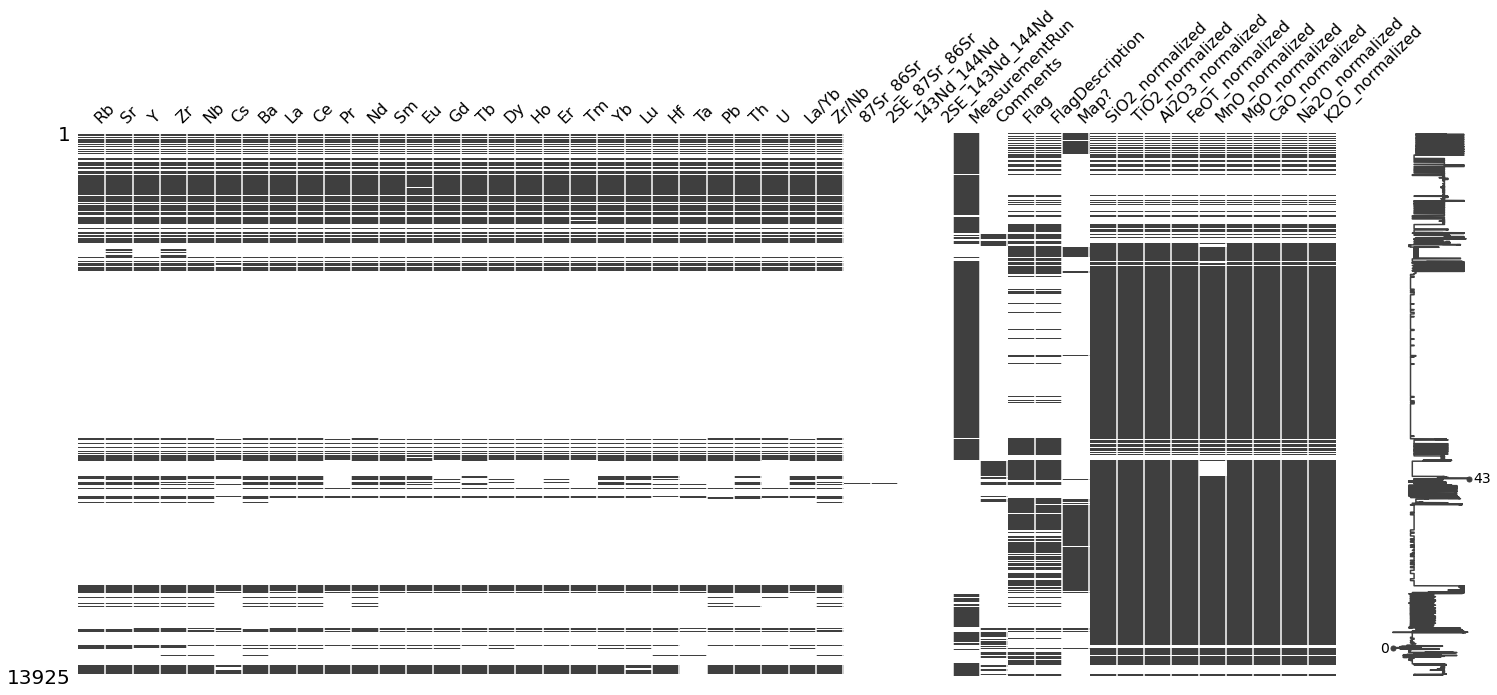

In [44]:
msno.matrix(df[df.Volcano!='Unknown'].loc[:,'Rb':'K2O_normalized'])